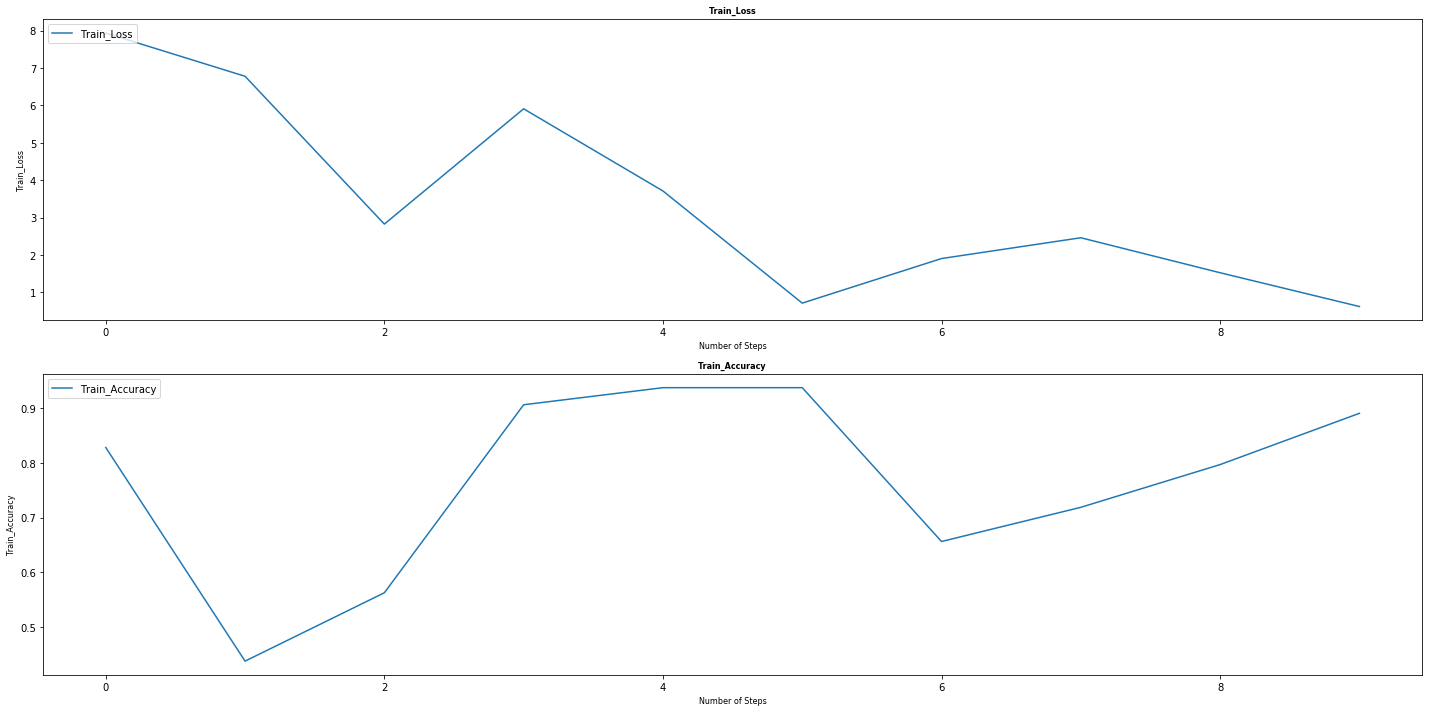

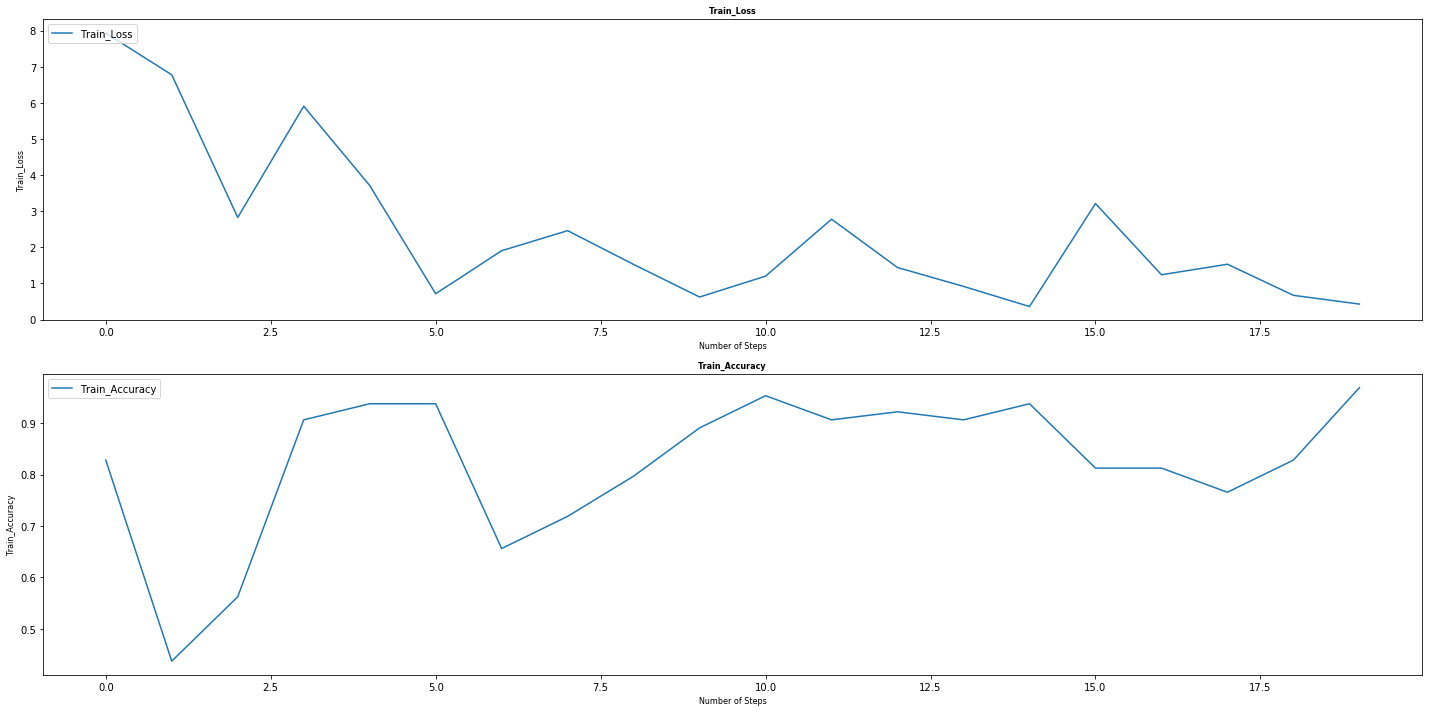

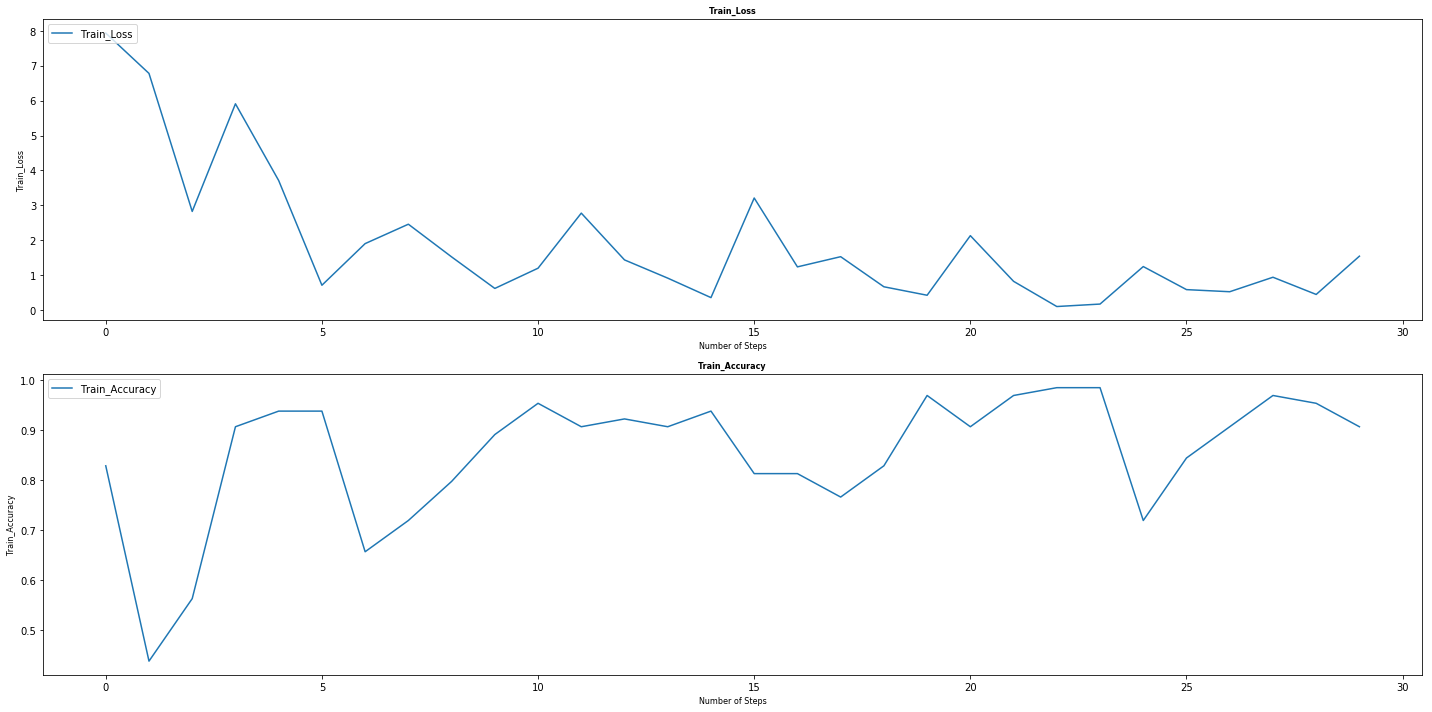

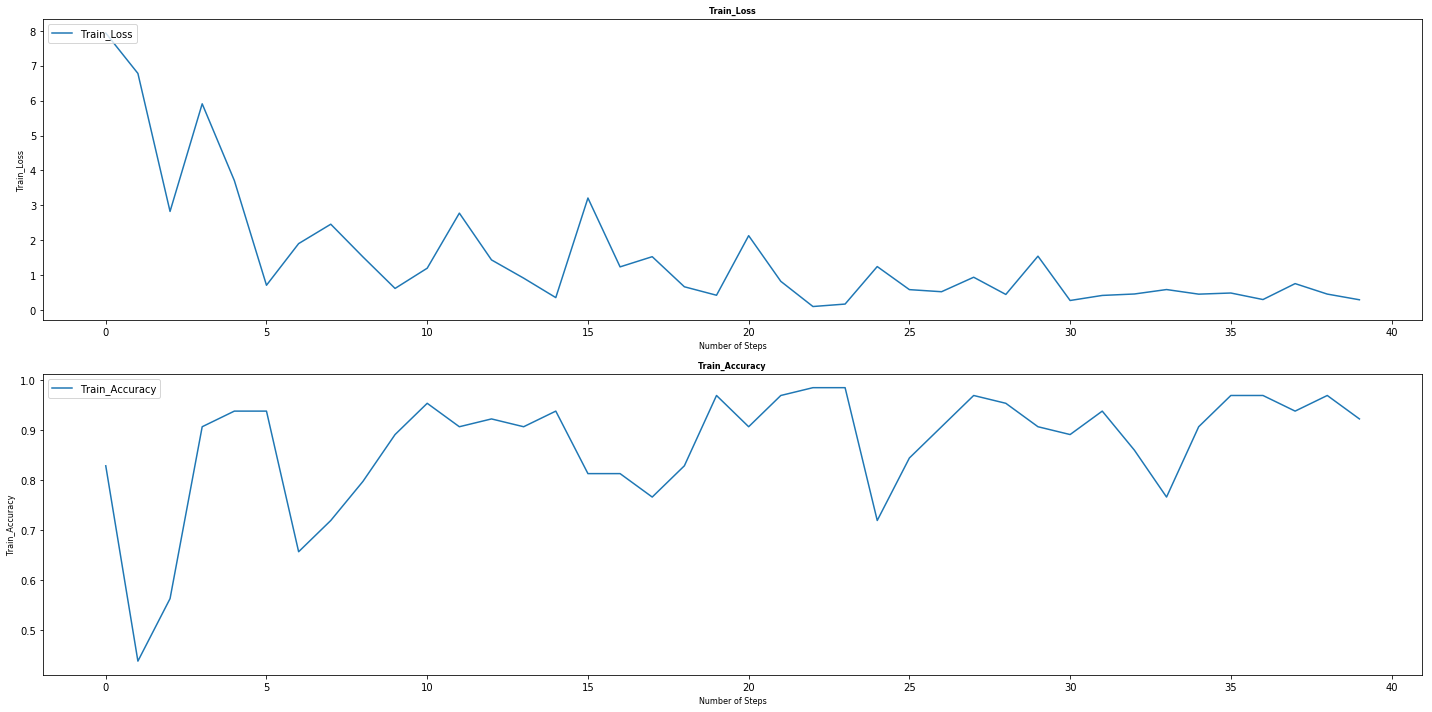

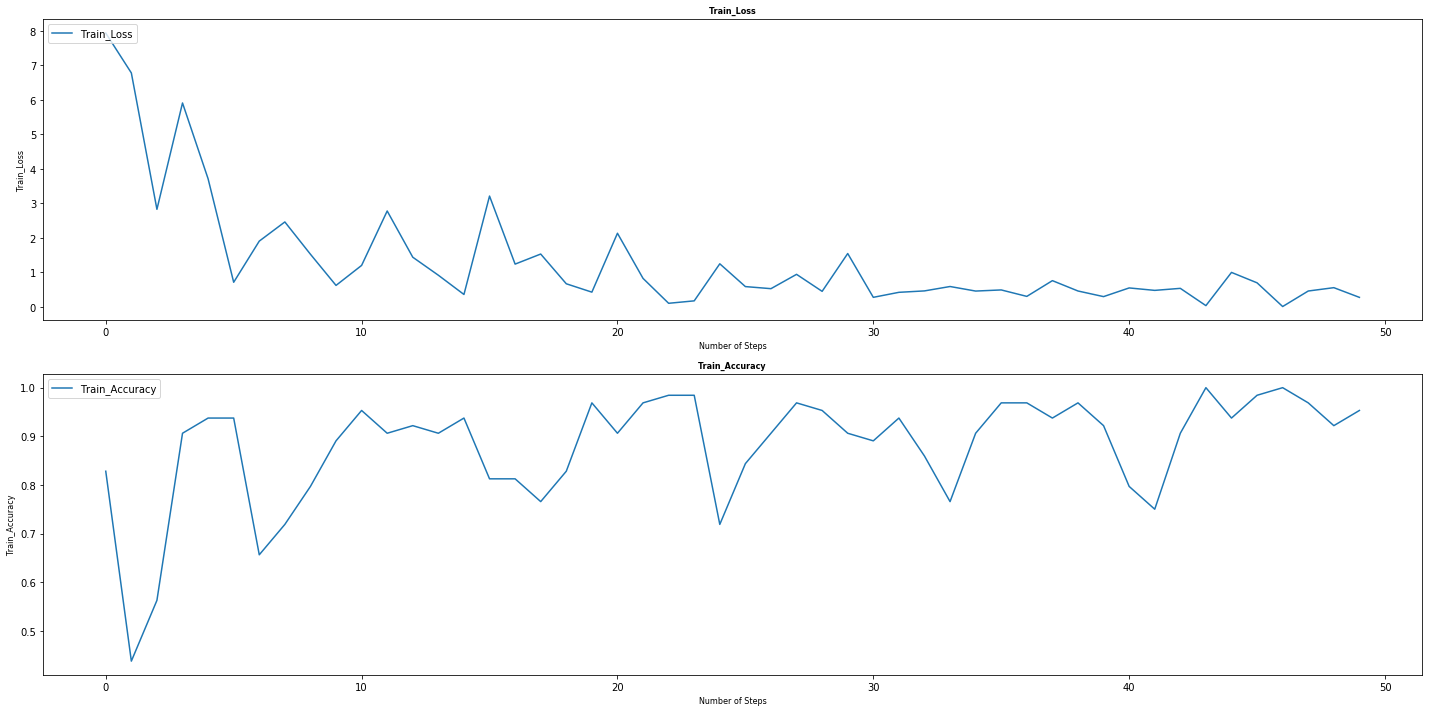

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from urllib.parse import urlparse
import os
import numpy as np
from IPython.display import clear_output, display
import time
from PIL import ImageTk, Image
import pandas as pd

from Constants import Constants, specialTokenList, specialTokens
from All_Models import SSCL, GatedCNN, SelfAttnModel
from utils import getSampler
from Trainers import Trainer, TkTrainer
from LoadData import loadingData, TkloadingData
import tkinter as tk

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("TkAgg")
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from matplotlib.figure import Figure


%matplotlib inline

'''
2. Output .exe
6. add Random Seed
7. Add test program
8. test the loading dataset
9. the Honeypot dataset == HSpam14
10. add scheduler

'''


class args(object):

    # Data

    dataset = ["HSpam14", "Honeypot"][1]
    full_data = True
    usingWeightRandomSampling = True
    vocab_size = 8000  # if we create the new vocab size, we have to do the new preprocess again
    validation_portion = 0.05
    test_portion = 0.04
    random_seed = 64
    
    scheduler_step = 2000
    scheduler_gamma = 0.85
    scheduler_minLr = 0.00001
    
    pickle_name = "FullPickleData" + str(vocab_size) + "Vocab.txt"
    pickle_name_beforeMapToIdx = "FullPickleDatabeforeMapToIdx.txt"

    # Arch

    # GatedCNN arch

    GatedCNN_embedingDim = 128
    GatedCNN_convDim = 64
    GatedCNN_kernel = 3
    GatedCNN_stride = 1
    GatedCNN_pad = 1
    GatedCNN_layers = 8
    GatedCNN_dropout = 0.1

    # SSCL arch

    SSCL_embedingDim = 128
    SSCL_RNNHidden = 128
    SSCL_CNNDim = 128
    SSCL_CNNKernel = 3
    SSCL_CNNDropout = 0.1
    SSCL_LSTMDropout = 0.1
    SSCL_LSTMLayers = 1

    # Attn arch

    SelfAttn_LenMaxSeq = 280  # Default, will be changed Later

    # These Two has to be the same
    SelfAttn_WordVecDim = 128
    SelfAttn_ModelDim = 128

    SelfAttn_FFInnerDim = 256
    SelfAttn_NumLayers = 3
    SelfAttn_NumHead = 4
    SelfAttn_KDim = 64
    SelfAttn_VDim = 64
    SelfAttn_Dropout = 0.1

    # Training params

    batch_size = 64
    L2 = 0.1
    threshold = 0.5
    lr = 0.002
    n_epoch = 50

    # If using Adam
    adam_beta1 = 0.9
    adam_beta2 = 0.999

    earlyStopStep = 100 # Set None if we don't want it
    earlyStopEpoch = 1

    # Logging the Training
    val_freq = 50
    val_steps = 3
    log_freq = 10
    model_save_freq = 1 # this hasn't been added
    model_name = 'SpamDetectionModel'
    model_path = './' + dataset + '_Log/' + model_name + '/Model/'
    log_path = './' + dataset + '_Log/' + model_name + '/Log/'


window = tk.Tk()
window.title('Spammer Detection')
window.geometry('1920x1080')


def setBoolHyerParams(window, var, text, x, y):
    c = tk.Checkbutton(window, text=text,
                       onvalue=True, offvalue=False, variable=var)
    c.grid(column=x,row=y, columnspan= 2)


def setHyperPrams(window, text, x, y):
    l = tk.Label(window,
                 text=text,    
                 font=('Arial', 12),    
                 )
#     l.place(x=x, y=y, anchor='nw')
    l.grid(column = x, row =y)
    e = tk.Entry(window)
#     e.place(x=(x+200), y=y, anchor="nw")
    e.grid(column = x+1, row =y)
    
    return l, e



def setModelHyperPrams(window, text, x, y):
    
    l = tk.Label(window,
             text=text,    
             font=('Arial', 12),    
             )
    l.grid(column=x, row=y, padx= 10)
    e = tk.Entry(window)
    e.grid(column=x, row=y+1, padx= 10)
    return l, e



def setRadioButtons(var, label, texts, values, command, x, y):

    l = tk.Label(window,
                 text=label,
                 font=('Arial', 12),
                 )
    l.grid(column=x, row=y)

    for t, v in zip(texts, values):
        y = y+1
        tk.Radiobutton(window, text=t, font=('Arial', 12),
                       variable=var, value=v,
                       command=command,).grid(column=x, row=y)


############### Dataset ###############

def Take_DatasetSelection():
    print("Selected Dataset: ", datasetSelected.get())


datasetSelected = tk.StringVar()

setRadioButtons(datasetSelected, "Dataset",
                ["HSpam14Dataset", "HoneypotDataset"], ['HSpam14', 'Honeypot'],
                Take_DatasetSelection, 0, 0)


############### Models ###############


def Take_ModelSelection():
    printHyperParamsSetting(window, modelSelected.get(), 250, 10)


modelSelected = tk.StringVar()

models_list = ['SSCL', 'GatedCNN', 'SelfAttn']

setRadioButtons(modelSelected, "Model", models_list,
                models_list, Take_ModelSelection, 0, 5)


x = 1
y = 0


GatedCNN_embedingDim_label, GatedCNN_embedingDim = setModelHyperPrams(
    window, "GatedCNN_embedingDim", x, y)
GatedCNN_convDim_label, GatedCNN_convDim = setModelHyperPrams(
    window, "GatedCNN_convDim", x, y+(1*2))
GatedCNN_kernel_label, GatedCNN_kernel = setModelHyperPrams(
    window, "GatedCNN_kernel", x, y+(2*2))
GatedCNN_stride_label, GatedCNN_stride = setModelHyperPrams(
    window, "GatedCNN_stride", x, y+(3*2))
GatedCNN_pad_label, GatedCNN_pad = setModelHyperPrams(
    window, "GatedCNN_pad", x, y+(4*2))
GatedCNN_layers_label, GatedCNN_layers = setModelHyperPrams(
    window, "GatedCNN_layers", x, y+(5*2))
GatedCNN_dropout_label, GatedCNN_dropout = setModelHyperPrams(
    window, "GatedCNN_dropout", x, y+(6*2))

SSCL_RNNHidden_label, SSCL_RNNHidden = setModelHyperPrams(
    window, "SSCL_RNNHidden", x, y)
SSCL_CNNDim_label, SSCL_CNNDim = setModelHyperPrams(
    window, "SSCL_CNNDim", x, y+(1*2))
SSCL_CNNKernel_label, SSCL_CNNKernel = setModelHyperPrams(
    window, "SSCL_CNNKernel", x, y+(2*2))
SSCL_CNNDropout_label, SSCL_CNNDropout = setModelHyperPrams(
    window, "SSCL_CNNDropout", x, y+(3*2))
SSCL_LSTMDropout_label, SSCL_LSTMDropout = setModelHyperPrams(
    window, "SSCL_LSTMDropout", x, y+(4*2))
SSCL_LSTMLayers_label, SSCL_LSTMLayers = setModelHyperPrams(
    window, "SSCL_LSTMLayers", x, y+(5*2))
SSCL_embedingDim_label, SSCL_embedingDim = setModelHyperPrams(
    window, "SSCL_embedingDim", x, y+(6*2))

SelfAttn_LenMaxSeq_label, SelfAttn_LenMaxSeq = setModelHyperPrams(
    window, "SelfAttn_LenMaxSeq", x, y)
SelfAttn_ModelDim_label, SelfAttn_ModelDim = setModelHyperPrams(
    window, "SelfAttn_ModelDim", x, y+(1*2))
SelfAttn_FFInnerDim_label, SelfAttn_FFInnerDim = setModelHyperPrams(
    window, "SelfAttn_FFInnerDim", x, y+(2*2))
SelfAttn_NumLayers_label, SelfAttn_NumLayers = setModelHyperPrams(
    window, "SelfAttn_NumLayers", x, y+(3*2))
SelfAttn_NumHead_label, SelfAttn_NumHead = setModelHyperPrams(
    window, "SelfAttn_NumHead", x, y+(4*2))
SelfAttn_KDim_label, SelfAttn_KDim = setModelHyperPrams(
    window, "SelfAttn_KDim", x, y+(5*2))
SelfAttn_VDim_label, SelfAttn_VDim = setModelHyperPrams(
    window, "SelfAttn_VDim", x, y+(6*2))
SelfAttn_Dropout_label, SelfAttn_Dropout = setModelHyperPrams(
    window, "SelfAttn_Dropout", x, y+(7*2))

GatedCNN_label = [
    GatedCNN_embedingDim_label,
    GatedCNN_convDim_label,
    GatedCNN_kernel_label,
    GatedCNN_stride_label,
    GatedCNN_pad_label,
    GatedCNN_layers_label,
    GatedCNN_dropout_label,
]

GatedCNN_entry = [
    GatedCNN_embedingDim,
    GatedCNN_convDim,
    GatedCNN_kernel,
    GatedCNN_stride,
    GatedCNN_pad,
    GatedCNN_layers,
    GatedCNN_dropout,
]

SSCL_label = [
    SSCL_RNNHidden_label,
    SSCL_CNNDim_label,
    SSCL_CNNKernel_label,
    SSCL_CNNDropout_label,
    SSCL_LSTMDropout_label,
    SSCL_LSTMLayers_label,
    SSCL_embedingDim_label
]

SSCL_entry = [
    SSCL_RNNHidden,
    SSCL_CNNDim,
    SSCL_CNNKernel,
    SSCL_CNNDropout,
    SSCL_LSTMDropout,
    SSCL_LSTMLayers,
    SSCL_embedingDim,
]


SelfAttn_label = [
    SelfAttn_LenMaxSeq_label,
    SelfAttn_ModelDim_label,
    SelfAttn_FFInnerDim_label,
    SelfAttn_NumLayers_label,
    SelfAttn_NumHead_label,
    SelfAttn_KDim_label,
    SelfAttn_VDim_label,
    SelfAttn_Dropout_label,
]

SelfAttn_entry = [

    SelfAttn_LenMaxSeq,
    SelfAttn_ModelDim,
    SelfAttn_FFInnerDim,
    SelfAttn_NumLayers,
    SelfAttn_NumHead,
    SelfAttn_KDim,
    SelfAttn_VDim,
    SelfAttn_Dropout,
]


def forgetLabelAndEntry(label, entry):
    for l, e in zip(label, entry):
        l.grid_forget()
        e.grid_forget()


forgetLabelAndEntry(SSCL_label, SSCL_entry)
forgetLabelAndEntry(SelfAttn_label, SelfAttn_entry)
forgetLabelAndEntry(GatedCNN_label, GatedCNN_entry)


def placeLabelAndEntry(labels, entries, x, y):
    for l, e in zip(labels, entries):
        l.grid(column=x, row=y, padx = 30)
        e.grid(column=x, row=(y+1), padx = 30)
        y = y + 2
        


def printHyperParamsSetting(window, model, x, y):

    x = 1
    y = 0

    if model == 'GatedCNN':

        forgetLabelAndEntry(SSCL_label, SSCL_entry)
        forgetLabelAndEntry(SelfAttn_label, SelfAttn_entry)
        placeLabelAndEntry(GatedCNN_label, GatedCNN_entry, x, y)

    elif model == "SSCL":

        # Have to fix this part in the SSCL Model

        forgetLabelAndEntry(GatedCNN_label, GatedCNN_entry)
        forgetLabelAndEntry(SelfAttn_label, SelfAttn_entry)
        placeLabelAndEntry(SSCL_label, SSCL_entry, x, y)

    elif model == "SelfAttn":

        forgetLabelAndEntry(GatedCNN_label, GatedCNN_entry)
        forgetLabelAndEntry(SSCL_label, SSCL_entry)
        placeLabelAndEntry(SelfAttn_label, SelfAttn_entry, x, y)

    else:
        raise ValueError


x = 2
y = 0

vocab_size_label, vocab_size = setHyperPrams(window, "vocab_size", x, y)
validation_portion_label, validation_portion = setHyperPrams(
    window, "validation_portion", x, (y+(1)))
test_portion_label, test_portion = setHyperPrams(
    window, "test_portion", x, (y+(2)))
batch_size_label, batch_size = setHyperPrams(
    window, "batch_size", x, (y+(3)))
L2_label, L2 = setHyperPrams(window, "L2", x, (y+(4)))
lr_label, lr = setHyperPrams(window, "lr", x, (y+(5)))
n_epoch_label, n_epoch = setHyperPrams(window, "n_epoch", x, (y+(6)))
earlyStopStep_label, earlyStopStep = setHyperPrams(
    window, "earlyStopStep", x, (y+(7)))
earlyStopEpoch_label, earlyStopEpoch = setHyperPrams(
    window, "earlyStopEpoch", x, (y+(8)))
val_freq_label, val_freq = setHyperPrams(window, "val_freq", x, (y+(9)))
val_steps_label, val_steps = setHyperPrams(window, "val_steps", x, (y+(10)))
log_freq_label, log_freq = setHyperPrams(window, "log_freq", x, (y+(11)))



model_save_freq_label, model_save_freq = setHyperPrams(window, "model_save_freq", x,  (y+(12)))
model_name_label, model_name = setHyperPrams(window, "model_name", x, (y+(13)))

scheduler_step_label, scheduler_step = setHyperPrams(window, "scheduler_step", x, (y+(14)))
scheduler_gamma_label, scheduler_gamma = setHyperPrams(window, "scheduler_gamma", x, (y+(15)))
scheduler_minLr_label, scheduler_minLr = setHyperPrams(window, "scheduler_minLr", x, (y+(16)))

usingWeightRandomSampling = tk.IntVar(value = args.usingWeightRandomSampling)
setBoolHyerParams(window, usingWeightRandomSampling,
                  "usingWeightRandomSampling", 0, (y+(16)))


resultTextbox = tk.Text(window , width = 90)
# resultTextbox.place(x=40, y=500, anchor='nw')

resultTextbox_scrollbar = tk.Scrollbar(window, orient="vertical", command=resultTextbox.yview)

resultTextbox.configure(yscrollcommand=resultTextbox_scrollbar.set)

resultTextbox_scrollbar.grid(column = 4, row = 17, sticky=tk.W+tk.S+tk.N)
# resultTextbox.pack(side="right", fill="y")
resultTextbox.grid(column = 0, row = 17, columnspan = 4)

vocab_size.insert("end", args.vocab_size)
validation_portion.insert("end", args.validation_portion)
test_portion.insert("end", args.test_portion)
batch_size.insert("end", args.batch_size)
L2.insert("end", args.L2)
lr.insert("end", args.lr)
n_epoch.insert("end", args.n_epoch)
earlyStopStep.insert("end", args.earlyStopStep)
earlyStopEpoch.insert("end", args.earlyStopEpoch)
val_freq.insert("end", args.val_freq)
val_steps.insert("end", args.val_steps)
log_freq.insert("end", args.log_freq)
model_save_freq.insert("end", args.model_save_freq)
model_name.insert("end", args.model_name)
scheduler_step.insert("end", args.scheduler_step )
scheduler_gamma.insert("end", args.scheduler_gamma )
scheduler_minLr.insert("end", args.scheduler_minLr)

GatedCNN_embedingDim.insert("end", args.GatedCNN_embedingDim)
GatedCNN_convDim.insert("end", args.GatedCNN_convDim)
GatedCNN_kernel.insert("end", args.GatedCNN_kernel)
GatedCNN_stride.insert("end", args.GatedCNN_stride)
GatedCNN_pad.insert("end", args.GatedCNN_pad)
GatedCNN_layers.insert("end", args.GatedCNN_layers)
GatedCNN_dropout.insert("end", args.GatedCNN_dropout)
SSCL_embedingDim.insert("end", args.SSCL_embedingDim)
SSCL_RNNHidden.insert("end", args.SSCL_RNNHidden)
SSCL_CNNDim.insert("end", args.SSCL_CNNDim)
SSCL_CNNKernel.insert("end", args.SSCL_CNNKernel)
SSCL_CNNDropout.insert("end", args.SSCL_CNNDropout)
SSCL_LSTMDropout.insert("end", args.SSCL_LSTMDropout)
SSCL_LSTMLayers.insert("end", args.SSCL_LSTMLayers)
SelfAttn_LenMaxSeq.insert("end", args.SelfAttn_LenMaxSeq)
SelfAttn_ModelDim.insert("end", args.SelfAttn_ModelDim)
SelfAttn_FFInnerDim.insert("end", args.SelfAttn_FFInnerDim)
SelfAttn_NumLayers.insert("end", args.SelfAttn_NumLayers)
SelfAttn_NumHead.insert("end", args.SelfAttn_NumHead)
SelfAttn_KDim.insert("end", args.SelfAttn_KDim)
SelfAttn_VDim.insert("end", args.SelfAttn_VDim)
SelfAttn_Dropout.insert("end", args.SelfAttn_Dropout)


def TakeNumOfParams():
    
    args.GatedCNN_embedingDim = int(GatedCNN_embedingDim.get())
    args.GatedCNN_convDim = int(GatedCNN_convDim.get())
    args.GatedCNN_kernel = int(GatedCNN_kernel.get())
    args.GatedCNN_stride = int(GatedCNN_stride.get())
    args.GatedCNN_pad = int(GatedCNN_pad.get())
    args.GatedCNN_layers = int(GatedCNN_layers.get())
    args.GatedCNN_dropout = float(GatedCNN_dropout.get())
    args.SSCL_embedingDim = int(SSCL_embedingDim.get())
    args.SSCL_RNNHidden = int(SSCL_RNNHidden.get())
    args.SSCL_CNNDim = int(SSCL_CNNDim.get())
    args.SSCL_CNNKernel = int(SSCL_CNNKernel.get())
    args.SSCL_CNNDropout = float(SSCL_CNNDropout.get())
    args.SSCL_LSTMDropout = float(SSCL_LSTMDropout.get())
    args.SSCL_LSTMLayers = int(SSCL_LSTMLayers.get())
    args.SelfAttn_LenMaxSeq = int(SelfAttn_LenMaxSeq.get())
    args.SelfAttn_ModelDim = int(SelfAttn_ModelDim.get())
    args.SelfAttn_FFInnerDim = int(SelfAttn_FFInnerDim.get())
    args.SelfAttn_NumLayers = int(SelfAttn_NumLayers.get())
    args.SelfAttn_NumHead = int(SelfAttn_NumHead.get())
    args.SelfAttn_KDim = int(SelfAttn_KDim.get())
    args.SelfAttn_VDim = int(SelfAttn_VDim.get())
    args.SelfAttn_Dropout = float(SelfAttn_Dropout.get())
    

    
    if modelSelected.get() == 'SSCL':
        resultTextbox.insert("end", "Using SSCL\n")
        trainModel = SSCL
    elif modelSelected.get() == 'GatedCNN':
        resultTextbox.insert("end", "Using GatedCNN\n")
        trainModel = GatedCNN
    elif modelSelected.get() == 'SelfAttn':
        resultTextbox.insert("end", "Using SelfAttn\n")
        trainModel = SelfAttnModel
    else:
        resultTextbox.insert("end", 'No Support For this Model')
        raise ValueError
        
    window.update_idletasks()
    resultTextbox.see("end")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainer = TkTrainer(trainModel, args, resultTextbox, window).to(device)
    
    
    resultTextbox.insert("end", ("Number of Parameters in this Model: " + str(trainer.num_all_params()) +"\n"))
    window.update_idletasks()
    resultTextbox.see("end")
    
    resultTextbox.insert("end",("Model Structure: \n" + str(trainer.model) + "\n"))
    window.update_idletasks()
    resultTextbox.see("end")


def StartTraining():

    training_Canvas = tk.Label(window)
    trainingAndVal_Canvas = tk.Label(window)
    
    resultTextbox.insert("end", "Training Start\n")
    window.update_idletasks()
    resultTextbox.see("end")
    
    ##### Init Args
    
    args.dataset = datasetSelected.get()
    
    args.vocab_size = int(vocab_size.get())
    args.validation_portion = float(validation_portion.get())
    args.test_portion = float(test_portion.get())
    args.batch_size = int(batch_size.get())
    args.L2 = float(L2.get())
    args.lr = float(lr.get())
    args.n_epoch = int(n_epoch.get())
    args.earlyStopStep = int(earlyStopStep.get())
    args.earlyStopEpoch = int(earlyStopEpoch.get())
    args.val_freq = int(val_freq.get())
    args.val_steps = int(val_steps.get())
    args.log_freq = int(log_freq.get())
    args.model_name = model_name.get()
    args.scheduler_step = int(scheduler_step.get())
    args.scheduler_gamma = float(scheduler_gamma.get())
    args.scheduler_minLr = float(scheduler_minLr.get())
    args.usingWeightRandomSampling = bool(usingWeightRandomSampling.get())

    args.GatedCNN_embedingDim = int(GatedCNN_embedingDim.get())
    args.GatedCNN_convDim = int(GatedCNN_convDim.get())
    args.GatedCNN_kernel = int(GatedCNN_kernel.get())
    args.GatedCNN_stride = int(GatedCNN_stride.get())
    args.GatedCNN_pad = int(GatedCNN_pad.get())
    args.GatedCNN_layers = int(GatedCNN_layers.get())
    args.GatedCNN_dropout = float(GatedCNN_dropout.get())
    args.SSCL_embedingDim = int(SSCL_embedingDim.get())
    args.SSCL_RNNHidden = int(SSCL_RNNHidden.get())
    args.SSCL_CNNDim = int(SSCL_CNNDim.get())
    args.SSCL_CNNKernel = int(SSCL_CNNKernel.get())
    args.SSCL_CNNDropout = float(SSCL_CNNDropout.get())
    args.SSCL_LSTMDropout = float(SSCL_LSTMDropout.get())
    args.SSCL_LSTMLayers = int(SSCL_LSTMLayers.get())
    args.SelfAttn_LenMaxSeq = int(SelfAttn_LenMaxSeq.get())
    args.SelfAttn_ModelDim = int(SelfAttn_ModelDim.get())
    args.SelfAttn_FFInnerDim = int(SelfAttn_FFInnerDim.get())
    args.SelfAttn_NumLayers = int(SelfAttn_NumLayers.get())
    args.SelfAttn_NumHead = int(SelfAttn_NumHead.get())
    args.SelfAttn_KDim = int(SelfAttn_KDim.get())
    args.SelfAttn_VDim = int(SelfAttn_VDim.get())
    args.SelfAttn_Dropout = float(SelfAttn_Dropout.get())
    
    args.model_path = './' + args.dataset + '_Log/' + args.model_name + '/Model/'
    args.log_path = './' + args.dataset + '_Log/' + args.model_name + '/Log/'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    args.device = device
    
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)

    if not os.path.exists(args.log_path):
        os.makedirs(args.log_path)
        
    training_dataset, validation_dataset, test_dataset, text = TkloadingData(args, resultTextbox, window)
    resultTextbox.see("end")
    
    args.numberOfSpammer = sum([t[-1] for t in training_dataset])
    args.numberOfNonSpammer = len(training_dataset)-args.numberOfSpammer
    args.len_max_seq = training_dataset[0][2]
    
    

    resultTextbox.insert("end", ("Number of Spammer: " +str(args.numberOfSpammer.item()) +"\n" ))
    resultTextbox.insert("end", ("Number of NonSpammer: " + str(args.numberOfNonSpammer.item()) +"\n" ))
    
    window.update_idletasks()
    
    
    if args.usingWeightRandomSampling:
        resultTextbox.insert("end", "Using WeightRandomSampling... \n")
        sampler = getSampler(training_dataset)
    else:
        resultTextbox.insert("end", "Not Using WeightRandomSampling... \n")
        sampler = None
    
    window.update_idletasks()
    
    train_loader = DataLoader(
        training_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False, sampler = sampler)
    valid_loader = DataLoader(
        validation_dataset, batch_size=args.batch_size, shuffle=True, drop_last=False)

    
    if modelSelected.get() == 'SSCL':
        resultTextbox.insert("end", "Using SSCL\n")
        trainModel = SSCL
    elif modelSelected.get() == 'GatedCNN':
        resultTextbox.insert("end", "Using GatedCNN\n")
        trainModel = GatedCNN
    elif modelSelected.get() == 'SelfAttn':
        resultTextbox.insert("end", "Using SelfAttn\n")
        trainModel = SelfAttnModel
    else:
        resultTextbox.insert("end", 'No Support For this Model')
        raise ValueError
        
    window.update_idletasks()
    
    trainer = TkTrainer(trainModel, args, resultTextbox, window).to(device)
                             
    resultTextbox.insert("end", ("Number of Parameters in this Model: " + str(trainer.num_all_params()) +"\n"))
    resultTextbox.insert("end", ("Using device: " + str(device) +"\n"))
    window.update_idletasks()
    
    
    args.using_scheduler = args.scheduler_step and args.scheduler_gamma < 1 and args.scheduler_gamma > 0
    
    if args.using_scheduler:
        scheduler = optim.lr_scheduler.StepLR(trainer.optim, args.scheduler_step, gamma=args.scheduler_gamma)
        
    # trainer.optim.param_groups[0]['lr']=
    allStep = 0
    epoch = 0
    
    resultTextbox.insert("end",("Model Structure: \n" + str(trainer.model) + "\n"))
    
    resultTextbox.see("end")
    
    window.update_idletasks()
    
    while epoch < args.n_epoch:
        for i, (texts, X , X_len, y) in enumerate(train_loader):

            trainer.train()
            X, X_len, y = X.to(device), X_len.to(device), y.to(device)
            
            
            if args.using_scheduler:
                if trainer.optim.param_groups[0]['lr'] >= args.scheduler_minLr:
                    scheduler.step()
                    
            start_t = time.time()
    #         trainer.train_step((X, X_len), y)
            trainer.train_step(X, y)

            end_t = time.time()
            allStep += 1
            resultTextbox.insert("end", ('| Epoch [%d] | Step [%d] | lr [%.6f] | Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs \n' %
                  (epoch, allStep, trainer.optim.param_groups[0]['lr'], trainer.loss.item(), trainer.accuracy.item(),
                   end_t - start_t)))
            window.update_idletasks()
            resultTextbox.see("end")
            
    #         if trainer.accuracy.item() > 0.95: # Stop early
    #             resultTextbox.insert("end", "Train Accuracy Reach the Stop Accuracy ")
    #             raise StopIteration
            if allStep % args.log_freq == 0:
            


                #################################################
    
                trainer.plot_train_hist(args.model_name)
    
                TrainImg = ImageTk.PhotoImage(Image.open(args.log_path+"Train_Loss&Acc_Hist_"+ str(args.model_name) +".png").resize((1000, 470), Image.ANTIALIAS))
                
                training_Canvas.config(image=TrainImg)
                
                training_Canvas.image = TrainImg
                
                training_Canvas.grid(column=5, row=0, rowspan= 16)
        
                window.update_idletasks()

            if args.earlyStopStep:
                if allStep >= args.earlyStopStep:
                    resultTextbox.insert("end", "EarlyStopStep Reach")
                    break


            if allStep % args.val_freq == 0:

                for _ in range(args.val_steps):
                    trainer.eval()
                    stIdx = np.random.randint(
                        0, len(validation_dataset) - args.batch_size)
                    v_text, v_X, v_X_len, v_y = validation_dataset[stIdx: stIdx +
                                                           args.batch_size]
                    v_X, v_X_len, v_y = v_X.to(
                        device), v_X_len.to(device), v_y.to(device)
                    start_t = time.time()
    #                 trainer.test_step((v_X, v_X_len), v_y)
                    trainer.test_step(v_X, v_y)
                    end_t = time.time()
                    resultTextbox.insert("end", ('| Epoch [%d] | Validation | Step [%d] |  Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs \n' %
                          (epoch, allStep, trainer.loss.item(), trainer.accuracy.item(), end_t - start_t)))
                    window.update_idletasks()
                    resultTextbox.see("end")
                    
                trainer.calculateAverage()
                clear_output()
                resultTextbox.insert("end",("TrainConfusion Matrix: \n"))
                resultTextbox.insert("end",pd.DataFrame(trainer.cms['Train'][-1]))
                resultTextbox.insert("end","\n\n")
                resultTextbox.insert("end",("ValidationConfusion Matrix: \n"))
                resultTextbox.insert("end",pd.DataFrame(trainer.cms['Val'][-1]))
                resultTextbox.insert("end","\n\n")
                window.update_idletasks()
                resultTextbox.see("end")
                
                
                
                #################################################
            
                trainer.plot_all(args.model_name)
                
                TrainAndValImg = ImageTk.PhotoImage(Image.open(args.log_path + "All_Hist_" + str(args.model_name) + ".png").resize((1000, 470), Image.ANTIALIAS))
                
                trainingAndVal_Canvas.config(image=TrainAndValImg)
                
                trainingAndVal_Canvas.image = TrainAndValImg
                
                trainingAndVal_Canvas.grid(column = 5 , row = 17)
                
                window.update_idletasks()

        
        epoch += 1
        trainer.model_save(epoch)


        if args.earlyStopEpoch:
            if epoch >= args.earlyStopEpoch:
                resultTextbox.insert("end", "EarlyStopEpoch Reach")
                break


    test_text, test_X, test_X_len, test_y  =  zip(test_dataset[0:])
    test_text, test_X, test_X_len, test_y = test_text[0], test_X[0].to(device), test_X_len[0].to(device), test_y[0].to(device)
    test_loss, test_accuracy, test_cm = trainer.test_step(test_X, test_y)

    
    resultTextbox.insert("end",("\n\n=========================================================================================" ))
    resultTextbox.insert("end",("\nThe Test Loss: " + str(test_loss.item()) + "\n" ))
    resultTextbox.insert("end",("The Test Accuracy: " + str(test_accuracy.item()) + "\n" ))
    resultTextbox.insert("end",("Test Confusion Matrix: \n"))
    resultTextbox.insert("end",(pd.DataFrame(test_cm)))
    resultTextbox.insert("end", "\n\n")               
    resultTextbox.see("end")
                
                
ShowModel = tk.Button(window,
                        text='Show Model',
                        width=15, height=2,
                        command=TakeNumOfParams)
# ShowModel.place(x=10, y=330, anchor="nw")

ShowModel.grid(column = 0, row = 10, rowspan = 2)
            
StartButton = tk.Button(window,
                        text='Strat Training',
                        width=15, height=2,
                        command=StartTraining)
StartButton.grid(column = 0, row = 13, rowspan = 2)





window.mainloop()